In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from dataloader import RealVsGeneratedDataset

/data2/.conda/envs/vqa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Adjusted for 3 channels
                         std=[0.229, 0.224, 0.225]),
])

from torch.utils.data import random_split

# Assuming a 80-20 split for train and validation sets
train_dataset = RealVsGeneratedDataset(root_dir='dataset', phase='train', transform=transform)
test_dataset = RealVsGeneratedDataset(root_dir="dataset", phase='val', transform=transform)
total_size = len(train_dataset)
train_size = int(total_size * 0.9)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
for i, (path, inputs, labels) in enumerate(test_dataloader):
    print(f"Batch {i+1}")
    print(f"Inputs shape: {inputs.shape}")
    print(f"Labels: {labels}")
    break


Batch 1
Inputs shape: torch.Size([32, 6, 224, 224])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [5]:
model = models.resnet50(pretrained=True)
# List of available ResNet variations in torchvision
# available_resnets = ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152",
#                      "resnext50_32x4d", "resnext101_32x8d",
#                      "wide_resnet50_2", "wide_resnet101_2"]

model.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for 6 channels


# Ensure the rest of the model is properly configured for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: Real and Generated

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/data2/.conda/envs/vqa/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data2/.conda/envs/vqa/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)  # Optional


Epoch 0/9, Loss: 0.1332, Acc: 0.9494, Val Loss: 0.0895, Val Acc: 0.9720
Epoch 1/9, Loss: 0.0734, Acc: 0.9747, Val Loss: 0.0359, Val Acc: 0.9886
Epoch 2/9, Loss: 0.0427, Acc: 0.9842, Val Loss: 0.0224, Val Acc: 0.9911
Epoch 3/9, Loss: 0.0174, Acc: 0.9941, Val Loss: 0.1728, Val Acc: 0.9568
Epoch 4/9, Loss: 0.0293, Acc: 0.9912, Val Loss: 0.0166, Val Acc: 0.9924
Epoch 5/9, Loss: 0.0137, Acc: 0.9959, Val Loss: 0.0500, Val Acc: 0.9860
Epoch 6/9, Loss: 0.0385, Acc: 0.9860, Val Loss: 0.0201, Val Acc: 0.9949
Epoch 7/9, Loss: 0.0078, Acc: 0.9973, Val Loss: 0.0044, Val Acc: 0.9987
Epoch 8/9, Loss: 0.0040, Acc: 0.9989, Val Loss: 0.0028, Val Acc: 0.9987
Epoch 9/9, Loss: 0.0033, Acc: 0.9992, Val Loss: 0.0019, Val Acc: 0.9987
Training complete
Model checkpoint saved as epoch_9_loss_0.0033_acc_0.9992_checkpoint.pth.


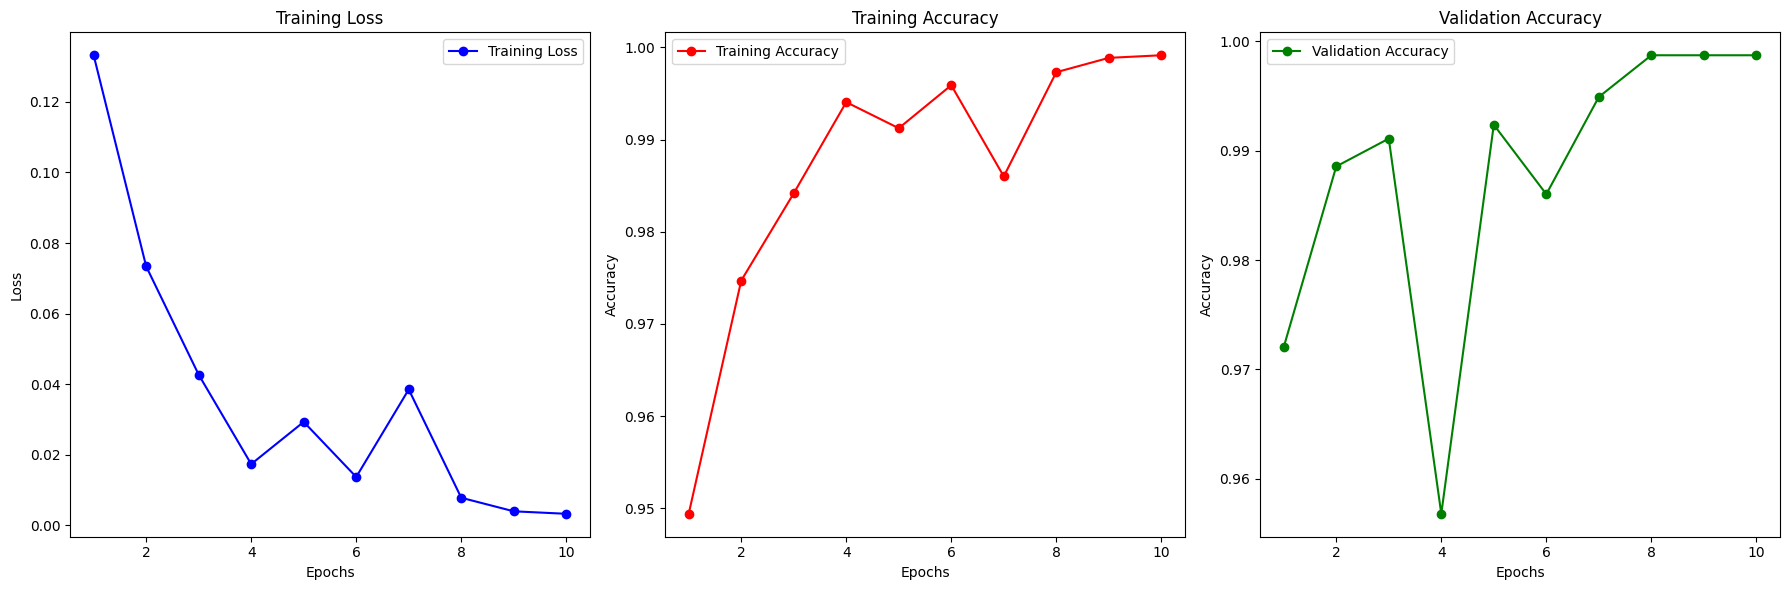

In [14]:
import matplotlib.pyplot as plt

# Initialize lists to store per-epoch loss and accuracy
train_loss_history = []
train_acc_history = []
val_acc_history = []

# Function to plot training history
def plot_training_history(loss_history, acc_history, val_acc_history):
    epochs = range(1, len(loss_history) + 1)
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss_history, 'bo-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs, acc_history, 'ro-', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_acc_history, 'go-', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

num_epochs = 10  # Adjust the number of epochs according to your needs

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    
    running_loss = 0.0
    running_corrects = 0

    for _, inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_corrects = 0

    for _, inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        val_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    scheduler.step()  # Adjust learning rate

    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc.cpu().detach().numpy())
    val_acc_history.append(val_acc.cpu().detach().numpy())

    # Validation loop can be added here

print('Training complete')

# Save the model checkpoint
checkpoint_filename = f'epoch_{epoch}_loss_{epoch_loss:.4f}_acc_{epoch_acc:.4f}_checkpoint.pth'
torch.save(model.state_dict(), checkpoint_filename)
print(f'Model checkpoint saved as {checkpoint_filename}.')

plot_training_history(train_loss_history, train_acc_history, val_acc_history)



# get confusion matrix

In [9]:
model.eval()  # Set model to evaluation mode
val_loss = 0.0
val_corrects = 0

for _, inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)

    val_loss += loss.item() * inputs.size(0)
    _, preds = torch.max(outputs, 1)
    val_corrects += torch.sum(preds == labels.data)

val_loss = val_loss / len(val_dataset)
val_acc = val_corrects.double() / len(val_dataset)

print(f'Testing Loss: {val_loss:.4f}, Testing Acc: {val_acc:.4f}')

# # Save the model checkpoint
# torch.save(model.state_dict(), 'model_checkpoint.pth')
# print('Model checkpoint saved.')


Testing Loss: 0.0612, Testing Acc: 2.7141


In [6]:
model_path = 'epoch_19_loss_0.0003_acc_1.0000_checkpoint.pth'
model.load_state_dict(torch.load(model_path))
model.eval()
print(f'Model loaded from {model_path}.')


Model loaded from epoch_19_loss_0.0003_acc_1.0000_checkpoint.pth.


In [18]:
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.forward_output = None

        # Hook for the gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook for the activations of the target layer
        def forward_hook(module, input, output):
            self.forward_output = output

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        # Forward pass
        output = self.model(input_image)
        if target_class is None:
            target_class = np.argmax(output.cpu().data.numpy())

        # Zero gradients
        self.model.zero_grad()

        # Target for backprop
        # one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
        # one_hot_output[0][target_class] = 1

        target_classes = output.argmax(dim=1)
        one_hot_output = torch.zeros_like(output)  # This creates a zero tensor with the same shape as the model's output
        one_hot_output.scatter_(1, target_classes.unsqueeze(1), 1)  # This sets the index of each target class to 1

        # Backward pass
        output.backward(gradient=one_hot_output)

        # output.backward(gradient=one_hot_output.to(input_image.device))

        # Generate CAM
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.forward_output.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))

        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_image.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam


In [19]:
# image = torch.from_numpy(image).permute(2, 0, 1).float()
# # image = image.unsqueeze(0)  # Add batch dimension
path, inputs, labels = next(iter(train_dataloader))
labels


tensor([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 0])

tensor(1)


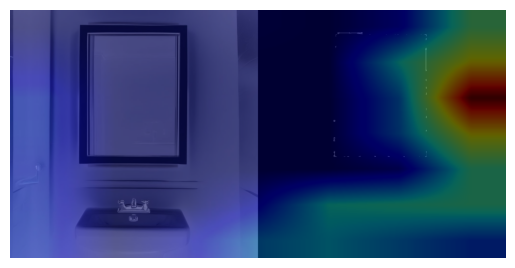

In [36]:
import matplotlib.pyplot as plt

def visualize_cam_on_image(original_image, cam):
    """
    Overlays the CAM heatmap on the original image.

    Parameters:
    - original_image: PyTorch tensor of shape [C, H, W] and normalized in the range [0, 1].
    - cam: 2D numpy array of the CAM.

    This function displays the resulting overlaid image.
    """
    # Normalize CAM
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    
    # Convert CAM to heatmap
    heatmap = plt.get_cmap('jet')(cam)[:, :, :3]  # Get the RGB values from the colormap
    heatmap = np.uint8(200 * heatmap)  # Convert to [0, 255]
    
    # Convert original image to numpy and denormalize
    # original_image = original_image.cpu().numpy().transpose(1, 2, 0)
    original_image = np.uint8(255 * original_image)  # Scale to [0, 255]
    
    # Resize heatmap to match original image's size
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    
    # Overlay heatmap on original image
    overlayed_image = cv2.addWeighted(original_image, 0.5, heatmap, 0.5, 0)
    
    # Display the image
    plt.imshow(overlayed_image)
    plt.axis('off')
    plt.show()


import cv2
i = 4
image_path = path[i]
splitpath = image_path.split('/')
splitpath[-2] = 'masks'
mask_path = '/'.join(splitpath)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
new_img = np.hstack((image, mask))



grad_cam = GradCAM(model, model.layer4[-1])
cam = grad_cam.generate_cam(inputs[i].unsqueeze(0).to(device), target_class=labels[i])  # For class 0, e.g., 'Real'
print(labels[i])
visualize_cam_on_image(new_img, cam)


In [23]:
mask_path

'dataset/Generated/train/masks/1423_512x640.jpg-gen2.png'

In [47]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [48]:
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)


In [79]:
import cv2
import matplotlib.pyplot as plt

def visualize_image_grad_cam(inputs, labels, i):
    grayscale_cam = cam(input_tensor=inputs, targets=None)
    grayscale_cam = grayscale_cam[i, :]

    image_path = path[i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if labels[i]:
        print("Generated Image ---------------------------")
    else:
        print("Real Image ---------------------------")

    image_normalized = image.astype(np.float32) / 255.0
    image_normalized = cv2.resize(image_normalized, (224, 224))

    viz_arr = show_cam_on_image(image_normalized, grayscale_cam, use_rgb=True)

    plt.imshow(viz_arr)
    plt.axis('off')  # Do not display axes for better visualization
    plt.show()


Real Image ---------------------------


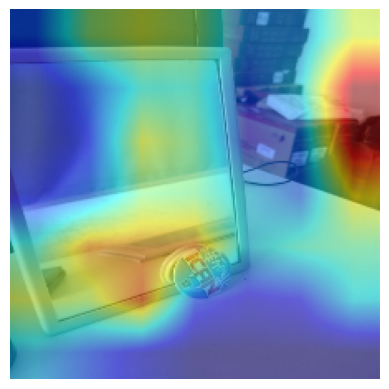

In [80]:
visualize_image_grad_cam(inputs, labels, 5)

Real Image ---------------------------


/data2/.conda/envs/vqa/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


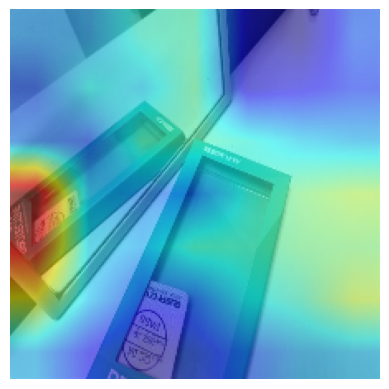

In [82]:
visualize_image_grad_cam(inputs, labels, 7)

Generated Image ---------------------------


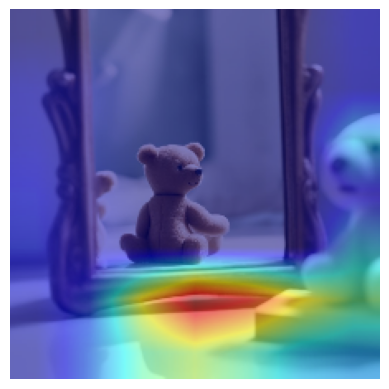

In [83]:
visualize_image_grad_cam(inputs, labels, 11)

Real Image ---------------------------


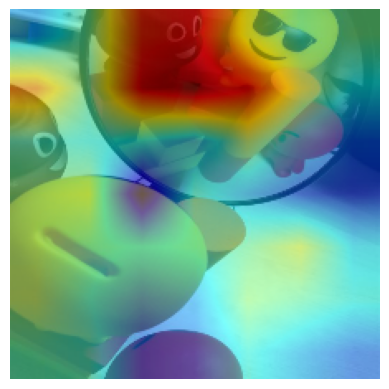

In [84]:
visualize_image_grad_cam(inputs, labels, 13)

Generated Image ---------------------------


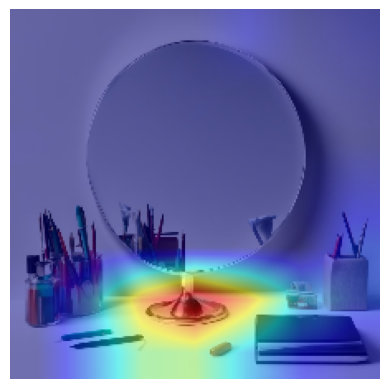

In [87]:
visualize_image_grad_cam(inputs, labels, 16)

Real Image ---------------------------


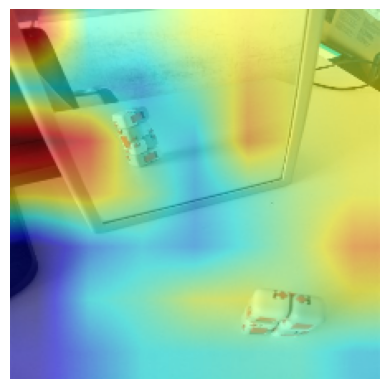

In [88]:
visualize_image_grad_cam(inputs, labels, 17)

Generated Image ---------------------------


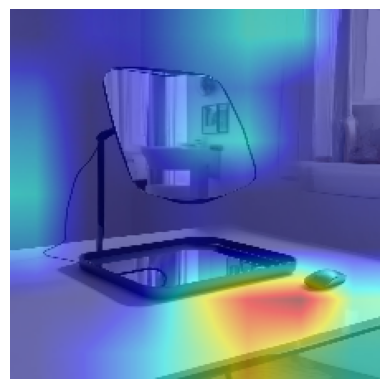

In [89]:
visualize_image_grad_cam(inputs, labels, 19)

Generated Image ---------------------------


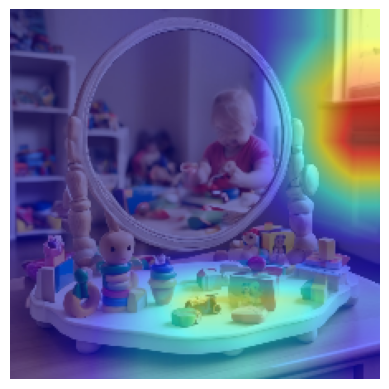

In [90]:
visualize_image_grad_cam(inputs, labels, 20)

Real Image ---------------------------


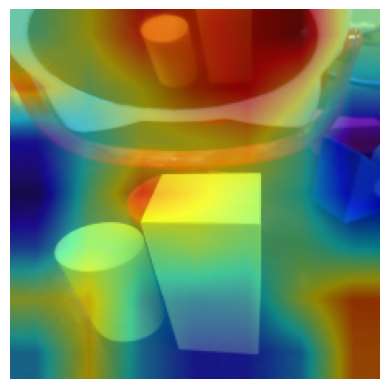

In [91]:
visualize_image_grad_cam(inputs, labels, 30)

Generated Image ---------------------------


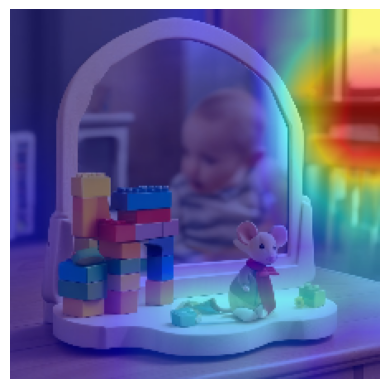

In [92]:
visualize_image_grad_cam(inputs, labels, 25)

Real Image ---------------------------


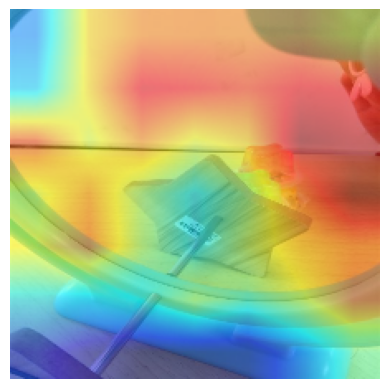

In [93]:
visualize_image_grad_cam(inputs, labels, 28)